# Instalasi Library dan Import Modul

In [1]:
!pip install PySastrawi
!pip install --upgrade transformers
!pip install --upgrade keras
!pip install --upgrade torch torchvision torchaudio
!pip install --upgrade accelerate

import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import torch
import html
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig, BertForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 kB 5.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 78.7 MB/s eta 0:00:00:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 514.8/514.8 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 69.4 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 67.1 MB/s eta 0:00:00:00:01
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.26.2
    Uninstalling huggingface-hub-0.26.2:
      Successfully uninstalled huggingface-hub-0.26.2
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.20.3
    Uninstalling tokenizers-0.20.3:
      Successfully uninstalled tokenizers-0.20.3
  Attempting uninstall: transformers
    Found existing installation: transformers 4.46.3
    Uninstalling transformers-4.46.3:
      Successfully uninstalled transformers-4.46.3
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Load Data

In [3]:
# Membaca dataset utama
df_dataset = pd.read_csv('/kaggle/input/dataset-pesan-judi-nonjudi/dataset.csv', encoding='utf-8')

# Membaca kamus alay (untuk normalisasi teks)
df_kamus_slang = pd.read_csv('/kaggle/input/dataset-pesan-judi-nonjudi/kamus_slang.csv', encoding='utf-8', header=None)
df_kamus_slang = df_kamus_slang.rename(columns={0: 'kata_asli', 1: 'kata_normalisasi'})

# Membaca daftar stopword bahasa Indonesia
df_stopword_id = pd.read_csv('/kaggle/input/dataset-pesan-judi-nonjudi/stopword_id.csv', encoding='utf-8', header=None)
df_stopword_id = df_stopword_id.rename(columns={0: 'stopword'})

In [4]:
print(df_dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17653 entries, 0 to 17652
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   full_text  17653 non-null  object
 1   label      17653 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 276.0+ KB
None


# Gambaran Dataset

In [5]:
# Mengatur opsi tampilan pandas
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Menampilkan informasi dataset
print("Dataset")
print("Shape: ", df_dataset.shape)
display(df_dataset.head(30))

# Tambahkan ruang setelah informasi dataset
print("\n" + "-"*50 + "\n")

# Menampilkan distribusi nilai pada kolom label
print("Distribusi Label")
print(df_dataset['label'].value_counts())

# Tambahkan ruang setelah distribusi label
print("\n" + "-"*50 + "\n")

# Menampilkan gambaran kamus alay
print("Kamus Slang")
print("Shape: ", df_kamus_slang.shape)
display(df_kamus_slang.head(10)) 

# Tambahkan ruang setelah kamus slang
print("\n" + "-"*50 + "\n")

# Menampilkan gambaran stopword bahasa Indonesia
print("Kamus Stopword")
print("Shape: ", df_stopword_id.shape)
display(df_stopword_id.head(10))

Dataset
Shape:  (17653, 2)


,full_text,label
0,RTP SLOT BANDUNGTOTO HARI INI 31 MARET 2025 #bandungtoto #rtpbandungtoto #rtpslotbandungtoto #rtpslot #rtpslotgacor #rtpslotharini https://t.co/NWly2Zn8hp,1
1,BUKTI KEMENANGAN MARETTOTO MARETTOTO SITUS SLOT ONLINE TERPERCAYA &amp; TERBESAR !! ️ Bonus Mega Rollingan Terbesar ️ Bonus New Member 20% ️ Cari Kami di Google : MARETTOTO Hubungi kami : +6287871203844 https://t.co/Y2o26K0Ydn,1
2,https://t.co/CwmyGlSX0H Member Withdraw IDR 2 000.000 JT Bersama DELIWIN Meraih KEMENANGAN !!!] * Daftar Situs DELIWIN Agen SLOT &amp; SABUNG AYAM Terbaik Se Asia Aman &amp; Terpercaya https://t.co/Mg5SP09eM8,1
3,https://t.co/CwmyGlSX0H Member Withdraw SABUNG AYAM IDR 5 000.000 JT Bersama DELIWIN Meraih KEMENANGAN !!!] *Daftar Situs DELIWIN Agen SLOT &amp; SABUNG AYAM Terbaik Se Asia Aman &amp; Terpercaya https://t.co/lV30SzRGS4,1
4,VIPGILABET88 - Situs Slot Gampang Maxwin Gilabet88 provider Slot Gacor sebagai tempat permainan situs slot paling mantull dengan keamanan paling terjaga dan sudah pastinya terpercaya. #slotgacor #gilabet88 #vipgilabet88 #gilaget888 #bandarslotgacor #agengacor #agenviral https://t.co/rIZh240iv6,1
5,Prediksi Sydney Night 26 Maret 2025 Monperatoto adalah Situs Togel Online Terpercaya Casino Terbaik Slot Gacor Di Indonesia #prediksihariini #prediksisdynight #monperatoto https://t.co/CvIQtZef6k,1
6,Prediksi Hongkong 25 Maret 2025 Monperatoto adalah Situs Togel Online Terpercaya Casino Terbaik Slot Gacor Di Indonesia #prediksihariini #prediksihk #monperatoto https://t.co/kdIlspxrCQ,1
7,Prediksi Sydney 25 Maret 2025 Monperatoto adalah Situs Togel Online Terpercaya Casino Terbaik Slot Gacor Di Indonesia #prediksihariini #prediksisdy #monperatoto https://t.co/vAad3pksEl,1
8,Buruan JOIN dan DAFTAR ketik di google JOS168 proses cepat hasil kilat bukan memberi harapan tapi itulah JOS168 Arena bermain SLOT ONLINE TOGEL LIVECASINO SPORTSBOOK COOCKFLIGHT terlengkap terpercaya dan terbesar SE INDONESIA https://t.co/h2aL1dfabS,1
9,JACKPOT DI KOTATOGEL JACKPOT SLOT GAME PG SOFT Rp 18.000.000 Dimana lagi kalau bukan di Kotatogel ! Berapapun pasti di bayar oleh Kotatogel Apapun games nya Main di sini sudah di jamin aman dan terpercaya bosku sayang karena JACKPOT BERAPAPUN PASTI KOTATOGEL BAYAR !! https://t.co/RXNh2SD6Is,1



--------------------------------------------------

Distribusi Label
label
1    10195
0     7458
Name: count, dtype: int64

--------------------------------------------------

Kamus Slang
Shape:  (16706, 2)


,kata_asli,kata_normalisasi
0,udah,sudah
1,gua,aku
2,ntar,nanti
3,be like,seperti
4,aja,saja
5,dah,sudah
6,anjir,anjing
7,begimana,bagaimana
8,online,daring
9,offline,luring



--------------------------------------------------

Kamus Stopword
Shape:  (758, 1)


,stopword
0,ada
1,adalah
2,adanya
3,adapun
4,agak
5,agaknya
6,agar
7,akan
8,akankah
9,akhir


# Cleaning Data

In [6]:
# Menampilkan jumlah baris sebelum pembersihan
print("Jumlah baris sebelum pembersihan: ", df_dataset.shape[0])

# Menghapus duplikat berdasarkan kolom 'cleaned_text'
df_dataset = df_dataset.drop_duplicates(subset=['full_text'])

# Menghapus baris dengan label yang kosong atau tidak sesuai dengan kategori yang didefinisikan
# Di sini saya hanya menggunakan label 0 dan 1 untuk kategori non-judi dan judi
df_dataset = df_dataset[df_dataset['label'].isin([0, 1])]

# Menampilkan jumlah baris setelah pembersihan
print("Jumlah baris setelah pembersihan: ", df_dataset.shape[0])

# Menampilkan distribusi label
print("Distribusi Label")
print(df_dataset['label'].value_counts())

Jumlah baris sebelum pembersihan:  17653
Jumlah baris setelah pembersihan:  13803
Distribusi Label
label
1    7505
0    6298
Name: count, dtype: int64


In [7]:
print(df_dataset.info())

<class 'pandas.core.frame.DataFrame'>
Index: 13803 entries, 0 to 17652
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   full_text  13803 non-null  object
 1   label      13803 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 323.5+ KB
None


# Preprocessing Data

In [8]:
def convert_to_lowercase(text):
    return text.lower()

def clean_text_content(text):
    text = html.unescape(text)  # Menghapus HTML entities (seperti &amp, &lt, &gt, dll.)
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)  # Menghapus karakter non-ASCII (termasuk emoticon)
    text = re.sub(r'@\w+', ' ', text)  # Menghapus mention (@username)
    text = re.sub(r'#\w+', ' ', text)  # Menghapus hashtag (#hashtag)
    text = re.sub(r'\n',' ',text)  # Menghapus setiap '\n'
    # text = re.sub(r'rt',' ',text)  # Menghapus simbol retweet 'RT'
    text = re.sub(r'user',' ',text)  # Menghapus nama pengguna
    text = re.sub(r'((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text)  # Menghapus URL
    text = re.sub(' +', ' ', text).strip()  # Menghilangkan spasi berlebih
    text = ' '.join([word for word in text.split() if len(word) >= 2])  # Menghapus kata kurang dari 2 huruf
    return text

def remove_non_alphanumeric(text):
    # Regex untuk menghapus tanda baca dan karakter non-alfanumerik (menjaga hanya huruf dan spasi)
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    return text

kamus_slang = dict(zip(df_kamus_slang['kata_asli'], df_kamus_slang['kata_normalisasi']))
def normalize_slang_words(text):
    return ' '.join([kamus_slang[word] if word in kamus_slang else word for word in text.split(' ')])

def remove_stopwords(text):
    text = ' '.join(['' if word in df_stopword_id.stopword.values else word for word in text.split(' ')])
    text = re.sub('  +', ' ', text) # Menghapus spasi ekstra
    text = text.strip()
    return text

def clean_unicode(text):
    # Regex untuk menghapus pola hex unicode (contoh: \xf0\x9f\x98\xad)
    text = re.sub(r'(\\x[a-fA-F0-9]{2})+', ' ', text)
    # Regex untuk menghapus entitas numerik (contoh: \u1234)
    text = re.sub(r'(\\u[a-fA-F0-9]{4})+', ' ', text)
    return text

def preprocessing_data(text):
    text = convert_to_lowercase(text)
    text = clean_text_content(text)
    text = remove_non_alphanumeric(text)
    text = clean_unicode(text)
    text = normalize_slang_words(text)
    text = remove_stopwords(text)
    return text

In [9]:
# Menghapus baris di mana kolom 'full_text' berisi NaN
df_dataset.dropna(subset=['full_text'], inplace=True)

# Menghapus baris di mana kolom 'full_text' hanya berisi spasi
df_dataset = df_dataset[df_dataset['full_text'].str.strip().astype(bool)]

# Memproses teks dengan fungsi preprocessing yang sudah ada
df_dataset['full_text'] = df_dataset['full_text'].apply(preprocessing_data)

# Menghapus duplikat setelah penerapan fungsi preprocessing berdasarkan kolom 'cleaned_text'
df_dataset = df_dataset.drop_duplicates(subset=['full_text'])

# Menghapus baris dengan label yang kosong atau tidak sesuai dengan kategori yang didefinisikan
df_dataset = df_dataset[df_dataset['label'].isin([0, 1])]

# Hasil Preprocessing

In [10]:
print(df_dataset.info())

# Tambahkan ruang setelah informasi dataset
print("\n" + "-"*50 + "\n")

# Menampilkan distribusi label
print("Distribusi Label")
print(df_dataset['label'].value_counts())

<class 'pandas.core.frame.DataFrame'>
Index: 10963 entries, 0 to 17652
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   full_text  10963 non-null  object
 1   label      10963 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 256.9+ KB
None

--------------------------------------------------

Distribusi Label
label
0    5818
1    5145
Name: count, dtype: int64


In [11]:
print("Shape: ", df_dataset.shape)
df_dataset.head(30)

Shape:  (10963, 2)


,full_text,label
0,rtp slot bandungtoto maret,1
1,bukti kemenangan marettoto marettoto situs slot daring terpercaya terbesar bonus mega rollingan terbesar bonus member cari google marettoto hubungi,1
2,member withdraw rupiah juta deliwin meraih kemenangan daftar situs deliwin agen slot sabung ayam terbaik asia aman terpercaya,1
3,member withdraw sabung ayam rupiah juta deliwin meraih kemenangan daftar situs deliwin agen slot sabung ayam terbaik asia aman terpercaya,1
4,vipgilabet situs slot gampang maxwin gilabet penyedia slot gacor permainan situs slot mantull keamanan terjaga pastinya terpercaya,1
5,prediksi sydney night maret monperatoto situs togel daring terpercaya casino terbaik slot gacor indonesia,1
6,prediksi hongkong maret monperatoto situs togel daring terpercaya casino terbaik slot gacor indonesia,1
7,prediksi sydney maret monperatoto situs togel daring terpercaya casino terbaik slot gacor indonesia,1
8,buruan gabung daftar ketik google hebat proses cepat hasil kilat harapan hebat arena bermain slot daring togel livecasino sportsbook coockflight terlengkap terpercaya terbesar indonesia,1
9,jackpot kotatogel jackpot slot game pergi lembut rupiah dimana kotatogel bayar kotatogel apapun games main jamin aman terpercaya bosku sayang jackpot kotatogel bayar,1


In [12]:
print("Shape: ", df_dataset.shape)
df_dataset.tail(30)

Shape:  (10963, 2)


,full_text,label
17623,grup basket sekolah tampil gacor kompetisi sekolah terkesan,0
17624,penampilan disc jockey klub malam gacor beat orang berdansa,0
17625,software edit foto gacor hasil editannya halus detail,0
17626,berolahraga rutin tubuh gacor bugar energik,0
17627,anak anak tampil panggung hiburan gacor energinya habis habis,0
17628,grup desain perusahaan meluncurkan produk gacor dipuji klien,0
17629,orang bergabung komunitas game gacor langsung masuk grup utama,0
17630,memperbaiki pengaturan performa komputer gacor lambat,0
17631,pertunjukan seni tari malam gacor penari penari profesional penuh ekspresi,0
17632,keputusan diambil manajer gacor proyek berjalan lancar,0


# Distribusi Label "Judi" dan "Non-Judi"

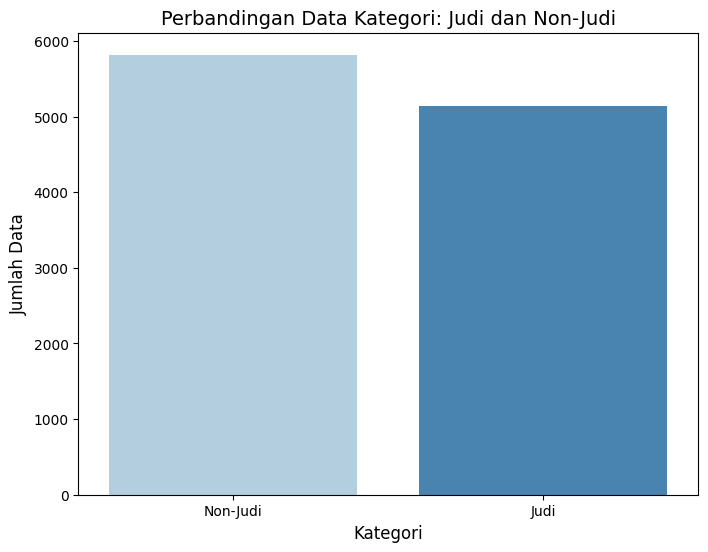

In [13]:
# Membuat salinan DataFrame untuk menghindari perubahan langsung pada df_dataset
categorized_data = df_dataset.copy()

# Kategorikan data berdasarkan label menjadi 'Judi' dan 'Non-Judi'
categorized_data['Category'] = categorized_data['label'].apply(lambda x: 'Judi' if x == 1 else 'Non-Judi')

# Hitung jumlah data untuk masing-masing kategori
category_counts = categorized_data['Category'].value_counts()

# Visualisasi perbandingan jumlah 'Judi' dan 'Non-Judi'
plt.figure(figsize=(8, 6))
sns.barplot(x=category_counts.index, y=category_counts.values, palette='Blues')
plt.title('Perbandingan Data Kategori: Judi dan Non-Judi', fontsize=14)
plt.xlabel('Kategori', fontsize=12)
plt.ylabel('Jumlah Data', fontsize=12)
plt.show()

# Save Preprocessing Data

In [14]:
df_dataset.to_csv('preprocessed_dataset.csv', index=False, encoding='utf-8')

# Load Preprocessing Data

In [15]:
print(df_dataset.info())

<class 'pandas.core.frame.DataFrame'>
Index: 10963 entries, 0 to 17652
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   full_text  10963 non-null  object
 1   label      10963 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 256.9+ KB
None


# Jumlah Kata dalam Teks

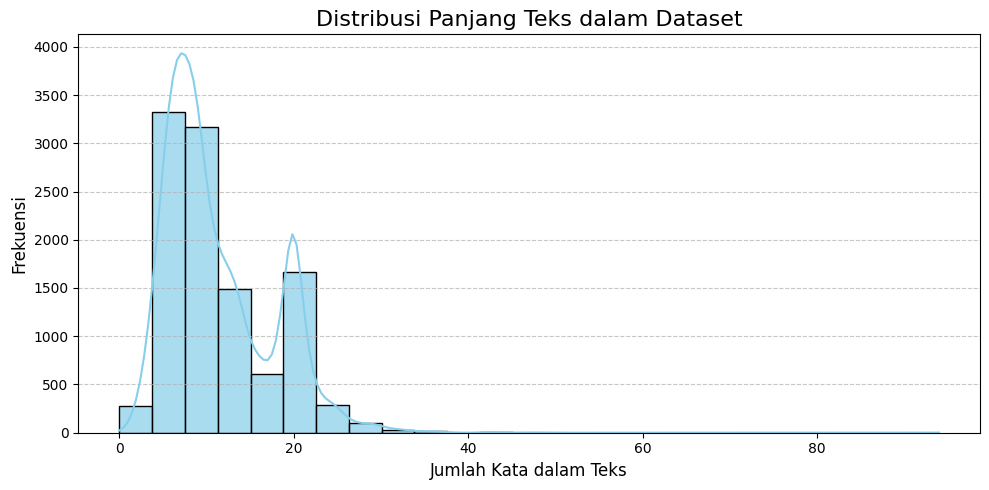

In [16]:
# Menghitung jumlah kata per tweet
word_count_per_tweet = df_dataset['full_text'].apply(lambda x: len(str(x).split()))
df_dataset['word_count'] = word_count_per_tweet

# Plot distribusi jumlah kata per tweet
plt.figure(figsize=(10, 5))
sns.histplot(df_dataset['word_count'], bins=25, kde=True, color='skyblue', alpha=0.7, edgecolor='black')
plt.title('Distribusi Panjang Teks dalam Dataset', fontsize=16)
plt.xlabel('Jumlah Kata dalam Teks', fontsize=12)
plt.ylabel('Frekuensi', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Menambahkan grid untuk sumbu y
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()  # Menyesuaikan layout agar lebih rapi
plt.show()

# WordCloud

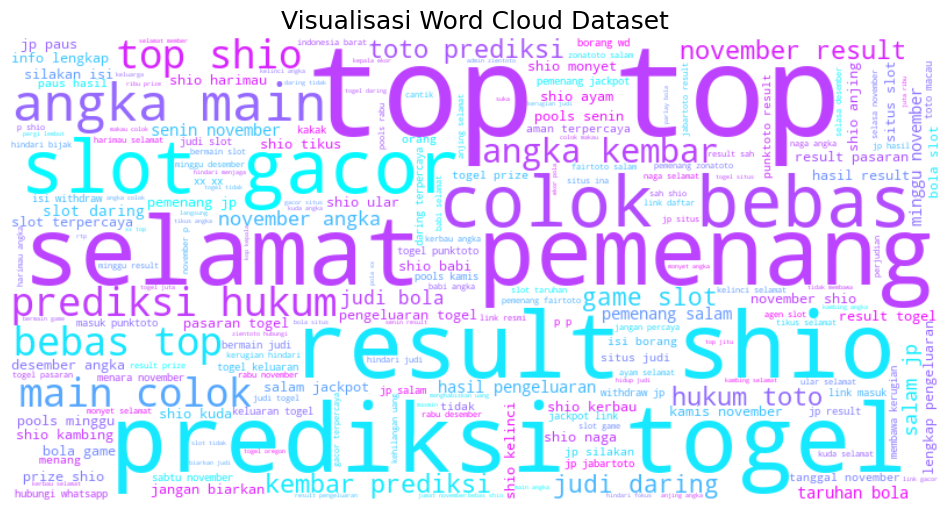

In [17]:
# Gabungkan semua teks menjadi satu string besar
all_words = ' '.join(df_dataset['full_text'])

# Membuat Word Cloud dengan warna gradien
wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='white', 
    colormap='cool',  # Menggunakan colormap 'cool' untuk variasi warna
    random_state=42, 
    max_font_size=110
).generate(all_words)

# Visualisasi Word Cloud
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')  # Menyembunyikan sumbu
plt.title('Visualisasi Word Cloud Dataset', fontsize=18)
plt.show()

# Model

# Menentukan Fitur dan Target

In [18]:
# Menentukan fitur dan target dari dataset
X = df_dataset['full_text']  # Fitur berupa teks yang sudah dipreprocessing
y = df_dataset['label']      # Target label (0 untuk non-judi, 1 untuk judi)

# Membagi Data Set Training, Testing dan Validasi

In [19]:
# Membagi data menjadi training (70%), validation (20%), dan test sets (10%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.3333, random_state=42, stratify=y_temp)

# Mencetak ukuran masing-masing dataset
print(f"Jumlah data pada training set: {X_train.shape[0]}")
print(f"Jumlah data pada validation set: {X_val.shape[0]}")
print(f"Jumlah data pada test set: {X_test.shape[0]}")

Jumlah data pada training set: 7674
Jumlah data pada validation set: 2192
Jumlah data pada test set: 1097


# Tokenizer dan Model

In [20]:
# Memuat tokenizer dan model IndoBERT yang sudah dilatih untuk klasifikasi
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p2')
config = BertConfig.from_pretrained(
    'indobenchmark/indobert-base-p2',
    num_labels=2,
    hidden_dropout_prob=0.8,
    attention_probs_dropout_prob=0.5
)
model = BertForSequenceClassification.from_pretrained(
    'indobenchmark/indobert-base-p2',
    config=config
)

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

# Tokenizing Data

In [21]:
# Fungsi untuk melakukan tokenisasi pada teks
def tokenize_function(examples):
    return tokenizer(examples, padding="max_length", truncation=True, max_length=512, return_tensors='pt')

# Menerapkan tokenisasi pada dataset training, validation, dan test
train_encodings = tokenize_function(X_train.tolist())
val_encodings = tokenize_function(X_val.tolist())
test_encodings = tokenize_function(X_test.tolist())

# Menyimpan tokenizer untuk digunakan nanti
save_path = './tokenizer'
tokenizer.save_pretrained(save_path)
print("Proses tokenisasi telah selesai")

Proses tokenisasi telah selesai


# Creating Dataset Class

In [22]:
# Definisi kelas dataset untuk digunakan pada Trainer
class JudiDetectionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels.tolist()

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Membuat objek dataset untuk training, validation, dan test
train_dataset = JudiDetectionDataset(train_encodings, y_train)
val_dataset = JudiDetectionDataset(val_encodings, y_val)
test_dataset = JudiDetectionDataset(test_encodings, y_test)

# Pelatihan Model

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {'accuracy': accuracy_score(labels, predictions)}

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=20,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    learning_rate=2e-5,
    weight_decay=0.3,
    warmup_steps=300,
    logging_dir='./logs',
    logging_steps=50,
    eval_strategy="epoch",                   # Evaluasi dilakukan di akhir setiap epoch
    save_strategy="epoch",                   # Menyimpan model di akhir setiap epoch
    load_best_model_at_end=True,             # Memuat model terbaik di akhir
    metric_for_best_model="eval_loss",       # Simpan model dengan val loss terendah
    greater_is_better=False,                 # Karena loss semakin kecil semakin baik
    save_total_limit=5                       # Hanya simpan model terbaik
)

# Callback EarlyStopping
early_stopping = EarlyStoppingCallback(early_stopping_patience=3)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping]
)

# Melakukan training
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy
1,0.764200,0.674239,0.564781
2,0.707100,0.502269,0.864964
3,0.366800,0.108332,0.961223
4,0.188900,0.080259,0.969434
5,0.145500,0.067553,0.976734
6,0.131100,0.064211,0.980383
7,0.135100,0.094243,0.969434
8,0.087800,0.054925,0.985401
9,0.097800,0.056466,0.985401
10,0.087800,0.054218,0.985858


TrainOutput(global_step=1800, training_loss=0.21646783391634622, metrics={'train_runtime': 6142.0783, 'train_samples_per_second': 18.741, 'train_steps_per_second': 0.293, 'total_flos': 3.02867135824896e+16, 'train_loss': 0.21646783391634622, 'epoch': 15.0})

In [24]:
# Evaluasi model pada test set
results = trainer.evaluate(test_dataset)
print(results)

{'eval_loss': 0.07259061932563782, 'eval_accuracy': 0.9826800364630811, 'eval_runtime': 17.9601, 'eval_samples_per_second': 61.08, 'eval_steps_per_second': 1.002, 'epoch': 15.0}


In [25]:
# Fungsi untuk memprediksi probabilitas pesan sebagai promosi judi atau non-judi
def predict_judi_probabilities(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs.to(model.device))
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=-1).squeeze()
    return {0: probabilities[0].item(), 1: probabilities[1].item()}

# Fungsi untuk mendapatkan label prediksi
def predict_judi(text):
    probabilities = predict_judi_probabilities(text)
    predicted_label = max(probabilities, key=probabilities.get)
    return predicted_label

# Fungsi untuk mendapatkan semua prediksi pada dataset
def get_predictions(X):
    predictions = [predict_judi(text) for text in X]
    return predictions

# Confusion Matrix

<Figure size 1000x1000 with 0 Axes>

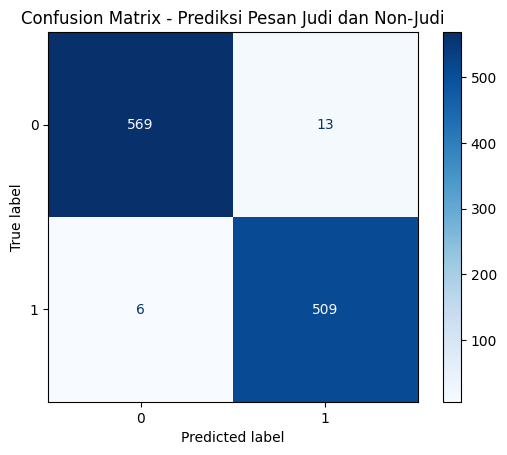

In [26]:
# Mendapatkan prediksi untuk test set
y_pred = get_predictions(X_test.tolist())

# Menghasilkan confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])

plt.figure(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Prediksi Pesan Judi dan Non-Judi")
plt.show()

# Evaluasi Model

In [27]:
# Menghitung dan menampilkan metrik evaluasi
target_names = ['Non-Judi', 'Judi']
report = classification_report(y_test, y_pred, target_names=target_names)
print(report)

              precision    recall  f1-score   support

    Non-Judi       0.99      0.98      0.98       582
        Judi       0.98      0.99      0.98       515

    accuracy                           0.98      1097
   macro avg       0.98      0.98      0.98      1097
weighted avg       0.98      0.98      0.98      1097



# Test Model

In [28]:
sample_text = "pesan anda sama sekali tidak terdeteksi sebagai promosi judi online, tidak ada kata kata yang mengandung judi online, dan tergolong sebagai pesan yang aman"

# Menghitung probabilitas setiap label
probabilities = predict_judi_probabilities(sample_text)

# Penjelasan tentang label
print("Label 0: Non-Judi (pesan tidak mengandung promosi judi)")
print("Label 1: Judi (pesan mengandung promosi judi)")

# Menampilkan probabilitas untuk setiap label
print("\nProbabilitas Label:")
for label, prob in probabilities.items():
    print(f"{label}: {prob:.4f}")

# Menentukan label dengan probabilitas tertinggi
predicted_label = max(probabilities, key=probabilities.get)

# Menampilkan label hasil prediksi
print(f"\nLabel Prediksi: {predicted_label}")

Label 0: Non-Judi (pesan tidak mengandung promosi judi)
Label 1: Judi (pesan mengandung promosi judi)

Probabilitas Label:
0: 0.9999
1: 0.0001

Label Prediksi: 0


In [41]:
sample_text = "Ketika mempromosikan situs judi Lumbung 88, Wulan Guritno secara eksplisit menyebut “game slot”. Bahkan ia menyebut bakal ada promo free chip atau saldo bagi member baru. Tidak ada sama sekali frasa “game online”. Semuanya sudah jelas meski ia mau berkelit bagaimana pun."

# Menghitung probabilitas setiap label
probabilities = predict_judi_probabilities(sample_text)

# Penjelasan tentang label
print("Label 0: Non-Judi (pesan tidak mengandung promosi judi)")
print("Label 1: Judi (pesan mengandung promosi judi)")

# Menampilkan probabilitas untuk setiap label
print("\nProbabilitas Label:")
for label, prob in probabilities.items():
    print(f"{label}: {prob:.4f}")

# Menentukan label dengan probabilitas tertinggi
predicted_label = max(probabilities, key=probabilities.get)

# Menampilkan label hasil prediksi
print(f"\nLabel Prediksi: {predicted_label}")

Label 0: Non-Judi (pesan tidak mengandung promosi judi)
Label 1: Judi (pesan mengandung promosi judi)

Probabilitas Label:
0: 0.9997
1: 0.0003

Label Prediksi: 0


In [30]:
sample_text = "Marî judî sl****t gaçor di juragãn 99 pasti gācor tiåp hari dijamin ayo júdi"

# Menghitung probabilitas setiap label
probabilities = predict_judi_probabilities(sample_text)

# Penjelasan tentang label
print("Label 0: Non-Judi (pesan tidak mengandung promosi judi)")
print("Label 1: Judi (pesan mengandung promosi judi)")

# Menampilkan probabilitas untuk setiap label
print("\nProbabilitas Label:")
for label, prob in probabilities.items():
    print(f"{label}: {prob:.4f}")

# Menentukan label dengan probabilitas tertinggi
predicted_label = max(probabilities, key=probabilities.get)

# Menampilkan label hasil prediksi
print(f"\nLabel Prediksi: {predicted_label}")

Label 0: Non-Judi (pesan tidak mengandung promosi judi)
Label 1: Judi (pesan mengandung promosi judi)

Probabilitas Label:
0: 0.0005
1: 0.9995

Label Prediksi: 1


In [31]:
sample_text = "III. Masa Kerajaan-kerajaan Islam (Abad ke-13 hingga Abad ke-16) *   Masuknya Islam: Islam masuk ke Nusantara melalui pedagang dari Gujarat, Persia, dan Arab. Proses islamisasi berlangsung secara bertahap dan damai. *   Munculnya Kerajaan-kerajaan Islam: *   Kerajaan Samudera Pasai (abad ke-13-16 M): Kerajaan Islam pertama di Indonesia, menjadi pusat perdagangan dan studi Islam. *   Kerajaan Demak (abad ke-15-16 M): Kerajaan Islam pertama di Jawa, menggantikan Majapahit, berperan penting dalam penyebaran Islam di Jawa. *   Kerajaan Pajang (abad ke-16 M): Kerajaan penerus Demak. *   Kerajaan Mataram Islam (abad ke-16-18 M): Kerajaan Islam yang kuat di Jawa, menguasai sebagian besar Jawa, meninggalkan warisan budaya seperti tradisi Sekaten dan upacara Grebeg. *   Kerajaan-kerajaan Islam lain: Kerajaan-kerajaan Islam lainnya juga muncul di berbagai wilayah seperti Gowa-Tallo di Sulawesi Selatan, Ternate-Tidore di Maluku, dan Banjar di Kalimantan. *   Akulturasi Budaya: Terjadi perpaduan antara budaya Islam dengan budaya lokal, melahirkan seni, arsitektur, dan tradisi baru. IV. Masa Kolonialisme Eropa (Abad ke-16 hingga Abad ke-20) 🤣 Mari judi slot gacor di juragan 99 pasti gacor tiap hari dijamin ayo judi🤣"

# Menghitung probabilitas setiap label
probabilities = predict_judi_probabilities(sample_text)

# Penjelasan tentang label
print("Label 0: Non-Judi (pesan tidak mengandung promosi judi)")
print("Label 1: Judi (pesan mengandung promosi judi)")

# Menampilkan probabilitas untuk setiap label
print("\nProbabilitas Label:")
for label, prob in probabilities.items():
    print(f"{label}: {prob:.4f}")

# Menentukan label dengan probabilitas tertinggi
predicted_label = max(probabilities, key=probabilities.get)

# Menampilkan label hasil prediksi
print(f"\nLabel Prediksi: {predicted_label}")

Label 0: Non-Judi (pesan tidak mengandung promosi judi)
Label 1: Judi (pesan mengandung promosi judi)

Probabilitas Label:
0: 0.2782
1: 0.7218

Label Prediksi: 1


In [44]:
sample_text = "timnas indo gacor sekarang"

# Menghitung probabilitas setiap label
probabilities = predict_judi_probabilities(sample_text)

# Penjelasan tentang label
print("Label 0: Non-Judi (pesan tidak mengandung promosi judi)")
print("Label 1: Judi (pesan mengandung promosi judi)")

# Menampilkan probabilitas untuk setiap label
print("\nProbabilitas Label:")
for label, prob in probabilities.items():
    print(f"{label}: {prob:.4f}")

# Menentukan label dengan probabilitas tertinggi
predicted_label = max(probabilities, key=probabilities.get)

# Menampilkan label hasil prediksi
print(f"\nLabel Prediksi: {predicted_label}")

Label 0: Non-Judi (pesan tidak mengandung promosi judi)
Label 1: Judi (pesan mengandung promosi judi)

Probabilitas Label:
0: 0.9793
1: 0.0207

Label Prediksi: 0


In [33]:
sample_text = "timnas indonesia lagi gacor sekarang"

# Menghitung probabilitas setiap label
probabilities = predict_judi_probabilities(sample_text)

# Penjelasan tentang label
print("Label 0: Non-Judi (pesan tidak mengandung promosi judi)")
print("Label 1: Judi (pesan mengandung promosi judi)")

# Menampilkan probabilitas untuk setiap label
print("\nProbabilitas Label:")
for label, prob in probabilities.items():
    print(f"{label}: {prob:.4f}")

# Menentukan label dengan probabilitas tertinggi
predicted_label = max(probabilities, key=probabilities.get)

# Menampilkan label hasil prediksi
print(f"\nLabel Prediksi: {predicted_label}")

Label 0: Non-Judi (pesan tidak mengandung promosi judi)
Label 1: Judi (pesan mengandung promosi judi)

Probabilitas Label:
0: 0.9993
1: 0.0007

Label Prediksi: 0


In [34]:
sample_text = "mending main slot aja di polo77 dijamin wd"

# Menghitung probabilitas setiap label
probabilities = predict_judi_probabilities(sample_text)

# Penjelasan tentang label
print("Label 0: Non-Judi (pesan tidak mengandung promosi judi)")
print("Label 1: Judi (pesan mengandung promosi judi)")

# Menampilkan probabilitas untuk setiap label
print("\nProbabilitas Label:")
for label, prob in probabilities.items():
    print(f"{label}: {prob:.4f}")

# Menentukan label dengan probabilitas tertinggi
predicted_label = max(probabilities, key=probabilities.get)

# Menampilkan label hasil prediksi
print(f"\nLabel Prediksi: {predicted_label}")

Label 0: Non-Judi (pesan tidak mengandung promosi judi)
Label 1: Judi (pesan mengandung promosi judi)

Probabilitas Label:
0: 0.0007
1: 0.9993

Label Prediksi: 1


In [35]:
sample_text = "hallo kak"

# Menghitung probabilitas setiap label
probabilities = predict_judi_probabilities(sample_text)

# Penjelasan tentang label
print("Label 0: Non-Judi (pesan tidak mengandung promosi judi)")
print("Label 1: Judi (pesan mengandung promosi judi)")

# Menampilkan probabilitas untuk setiap label
print("\nProbabilitas Label:")
for label, prob in probabilities.items():
    print(f"{label}: {prob:.4f}")

# Menentukan label dengan probabilitas tertinggi
predicted_label = max(probabilities, key=probabilities.get)

# Menampilkan label hasil prediksi
print(f"\nLabel Prediksi: {predicted_label}")

Label 0: Non-Judi (pesan tidak mengandung promosi judi)
Label 1: Judi (pesan mengandung promosi judi)

Probabilitas Label:
0: 0.9954
1: 0.0046

Label Prediksi: 0


In [36]:
sample_text = "Kotabaru - FM dan AM, dua karyawan bank BUMN di Kotabaru, Kalimantan Selatan (Kalsel), harus mendekam dibalik jeruji besi usai ketahuan menggelapkan dana nasabah. FM diduga ketagihan judi online dan nekat memanipulasi setoran tunai dibantu rekannya AM. Kejadian ini diketahui sudah dijalankan sejak Agustus 2023 hingga Oktober 2023. Keduanya, bersekongkol untuk melakukan setoran tunai fiktif ke rekening pribadi. Keduanya sudah diamankan dan mengakui perbuatannya, ujar Kapolres Kotabaru AKBP Dolly M Tanjung, Selasa (20/5/2025)."

# Menghitung probabilitas setiap label
probabilities = predict_judi_probabilities(sample_text)

# Penjelasan tentang label
print("Label 0: Non-Judi (pesan tidak mengandung promosi judi)")
print("Label 1: Judi (pesan mengandung promosi judi)")

# Menampilkan probabilitas untuk setiap label
print("\nProbabilitas Label:")
for label, prob in probabilities.items():
    print(f"{label}: {prob:.4f}")

# Menentukan label dengan probabilitas tertinggi
predicted_label = max(probabilities, key=probabilities.get)

# Menampilkan label hasil prediksi
print(f"\nLabel Prediksi: {predicted_label}")

Label 0: Non-Judi (pesan tidak mengandung promosi judi)
Label 1: Judi (pesan mengandung promosi judi)

Probabilitas Label:
0: 0.8121
1: 0.1879

Label Prediksi: 0


In [37]:
sample_text = "Kementerian Komunikasi dan Digital (Komdigi) telah memblokir jutaan konten judi online (judol) pada periode 20 Oktober 2024 - 7 Mei 2025, yang memberi dampak besar pada transkasi aktivitas haram tersebut. Ini merupakan bagian dari upaya Komdigi untuk memberantas judi online di Indonesia, yang terus menerus meresahkan masyarakat."

# Menghitung probabilitas setiap label
probabilities = predict_judi_probabilities(sample_text)

# Penjelasan tentang label
print("Label 0: Non-Judi (pesan tidak mengandung promosi judi)")
print("Label 1: Judi (pesan mengandung promosi judi)")

# Menampilkan probabilitas untuk setiap label
print("\nProbabilitas Label:")
for label, prob in probabilities.items():
    print(f"{label}: {prob:.4f}")

# Menentukan label dengan probabilitas tertinggi
predicted_label = max(probabilities, key=probabilities.get)

# Menampilkan label hasil prediksi
print(f"\nLabel Prediksi: {predicted_label}")

Label 0: Non-Judi (pesan tidak mengandung promosi judi)
Label 1: Judi (pesan mengandung promosi judi)

Probabilitas Label:
0: 0.9998
1: 0.0002

Label Prediksi: 0


# Save Model

In [45]:
import zipfile
import os

# Lokasi folder yang ingin diarsipkan
folder_path = '/kaggle/working/results/checkpoint-1560'
# Lokasi dan nama file zip hasil arsip
zip_path = '/kaggle/working/checkpoint-1560.zip'

# Membuat file zip dari folder
with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            # Membuat path lengkap dari file
            full_path = os.path.join(root, file)
            # Menambahkan file ke dalam arsip zip
            zipf.write(full_path, os.path.relpath(full_path, os.path.join(folder_path, '..')))

# Pesan konfirmasi setelah arsip selesai
print(f"Folder {folder_path} telah berhasil diarsipkan menjadi {zip_path}")

Folder /kaggle/working/results/checkpoint-1560 telah berhasil diarsipkan menjadi /kaggle/working/checkpoint-1560.zip


In [46]:
from IPython.display import FileLink
FileLink(r'checkpoint-1560.zip')

/kaggle/working/checkpoint-1560.zip